### Regression modeling.
> supervised learning regression models are trained to predict Airbnb listing prices based on the prepared dataset

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt

In [2]:
df_path = Path("../data/processed/airbnb_nyc_cleaned.csv")
df = pd.read_csv(df_path)
df.shape

(48410, 19)

In [3]:
# target variable
y = df["price"]

In [4]:
# feature variables
X = df.drop(
    columns=[
        "price",
        "id",
        "host_id",
        "name",
        "host_name"
    ]
)

X.shape

(48410, 14)

In [5]:
# as regression requires only numerical features, i will one hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)
X.shape

(48410, 238)

In [6]:
# split data into training and testing sets, 80% training, 20% testing

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [7]:
# train linear regression model

lr = LinearRegression()
lr.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [8]:
# evaluate linear regression model

y_pred_lr = lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

mae_lr, rmse_lr

(49.78174199502856, np.float64(79.65577555183259))

In [9]:
# k-fold cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [10]:
# model stability using k-fold cross-validation

cv_rmse_lr = -cross_val_score(
    lr,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=cv
)

cv_rmse_lr.mean(), cv_rmse_lr.std()
# high error + high variance = underfitting risk

(np.float64(79.84765900618115), np.float64(0.9737143830241863))

As EDA showed weak linear correlations, I will try decision tree and random forest models to capture non-linear relationships.

In [11]:
# train decision tree regressor

dt = DecisionTreeRegressor(
    max_depth=10,
    random_state=42
)

dt.fit(X_train, y_train)

,"criterion criterion: {""squared_error"", ""friedman_mse"", ""absolute_error"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in the half mean Poisson deviance to find splits... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 0.24 Poisson deviance criterion.",'squared_error'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.For an example of how ``max_depth`` influences the model, see:ref:`sphx_glr_auto_examples_tree_plot_tree_regression.py`.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_lea

In [12]:
# evaluate decision tree regressor

y_pred_dt = dt.predict(X_test)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))

mae_dt, rmse_dt

(46.97433748245294, np.float64(78.39725027760963))

In [13]:
# model stability using k-fold cross-validation

cv_rmse_dt = -cross_val_score(
    dt,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=cv
)

cv_rmse_dt.mean(), cv_rmse_dt.std()
# Lower training error + higher variance = overfitting risk.

(np.float64(80.59166429204257), np.float64(0.47359955663931463))

To reduce overfitting (high variance) and improve generalization, I will try a random forest regressor.

In [14]:
# train random forest regressor

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",15
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

In [15]:
# evaluate random forest regressor

y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

mae_rf, rmse_rf

(44.255511487190866, np.float64(72.4870857415608))

In [16]:
# model stability using k-fold cross-validation

cv_rmse_rf = -cross_val_score(
    rf,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=cv
)

cv_rmse_rf.mean(), cv_rmse_rf.std()
# Lower error + lower variance = better generalization.

(np.float64(74.31654871860012), np.float64(0.9711071643369803))

### Summarize model performance

In [17]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Decision Tree", "Random Forest"],
    "MAE": [mae_lr, mae_dt, mae_rf],
    "RMSE": [rmse_lr, rmse_dt, rmse_rf],
    "CV_RMSE_Mean": [
        cv_rmse_lr.mean(),
        cv_rmse_dt.mean(),
        cv_rmse_rf.mean()
    ]
})

In [18]:
results

,Model,MAE,RMSE,CV_RMSE_Mean
0,Linear Regression,49.781742,79.655776,79.847659
1,Decision Tree,46.974337,78.397250,80.591664
2,Random Forest,44.255511,72.487086,74.316549


### Check features importance from random forest model

In [19]:
# distance_from_subway
# distance from manhattan center

importances = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importances.head()

room_type_Private room      0.297190
distance_to_manhattan_km    0.142881
longitude                   0.103074
availability_365            0.080905
latitude                    0.053808
dtype: float64

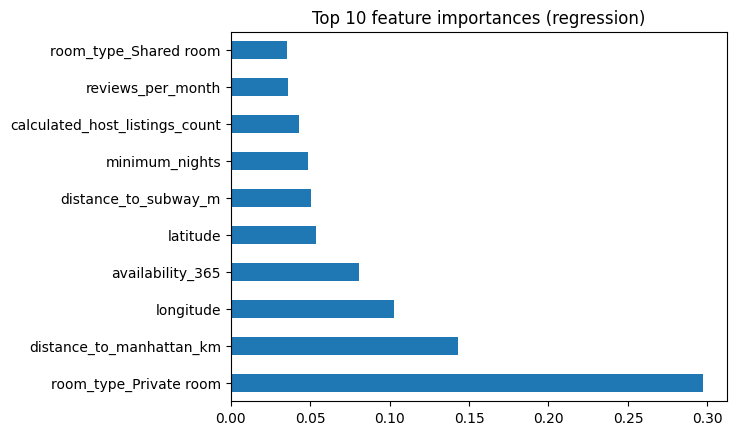

In [21]:
importances.head(10).plot(kind="barh")
plt.title("Top 10 feature importances (regression)")
plt.savefig("../figures/regression/feature_importances_regression.png", dpi=300)
plt.show()